
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/ahoust17/MLSTEM2024//main/Day1/Atom_Segmentation.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day1/Atom_Segmentation.ipynb)

# Training a U-Net to Segment Noisy Atomic Resolution Images

**Speaker: Austin Houston**

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>

<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

Install AtomAI:

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

print('installing atomai')
!pip install git+https://github.com/pycroscopy/atomai

Imports:

In [1]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import pyTEMlib.file_tools as ft

## Semantic segmentation

Download training/test data:

In [2]:
# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npz')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']


print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)


In [3]:
# Load real data

dataset = ft.open_file('')
image_stack = dataset['Channel_000']

# normalization
image_stack -= np.min(image_stack)
image_stack /= np.max(image_stack)

view = image_stack.plot()
print('Shape:', image_stack.shape)
print('Pixel size:', image_stack.original_metadata)

(80, 256, 256) (80, 256, 256)
(20, 256, 256) (20, 256, 256)


Let's plot some of the training data:

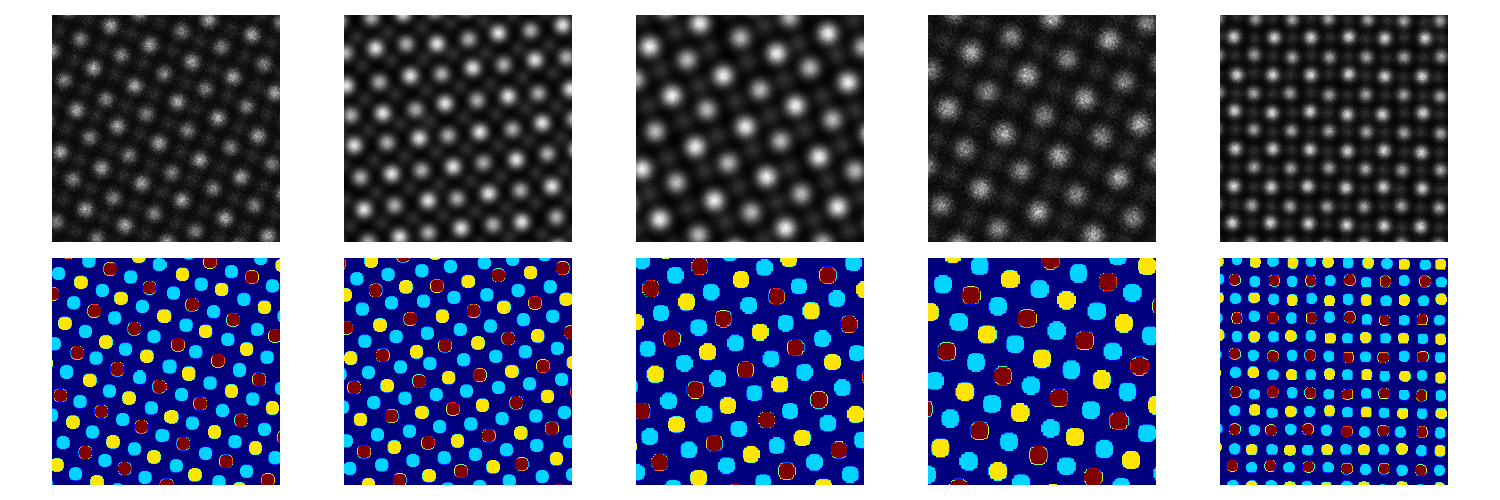

In [4]:
n = 5 # number of images to plot

fig, axs = plt.subplots(2, n, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(labels[i], cmap='jet')
    axs[1, i].axis('off')
fig.tight_layout()

Initialize a nodel for semantic segmentation:

In [5]:
model = aoi.models.Segmentor(nb_classes=2)

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

/Users/austin/miniconda3/envs/mlstem_env/lib/python3.12/site-packages/atomai/utils/preproc.py:54: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/Users/austin/miniconda3/envs/mlstem_env/lib/python3.12/site-packages/atomai/utils/preproc.py:59: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(


Epoch 1/300 ... Training loss: 1.7496 ... Test loss: 1.528 ... Train Accuracy: 0.1946 ... Test Accuracy: 0.1734 ... GPU memory usage: N/A / N/A
Epoch 100/300 ... Training loss: 0.3315 ... Test loss: 0.524 ... Train Accuracy: 0.8314 ... Test Accuracy: 0.5413 ... GPU memory usage: N/A / N/A
Epoch 200/300 ... Training loss: 0.1515 ... Test loss: 0.2176 ... Train Accuracy: 0.8854 ... Test Accuracy: 0.8233 ... GPU memory usage: N/A / N/A
Epoch 300/300 ... Training loss: 0.1518 ... Test loss: 0.1943 ... Train Accuracy: 0.8616 ... Test Accuracy: 0.7879 ... GPU memory usage: N/A / N/A
Model (final state) evaluation loss: 0.2079
Model (final state) accuracy: 0.8025
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.1898
Model (final state) accuracy: 0.827
Plotting training history


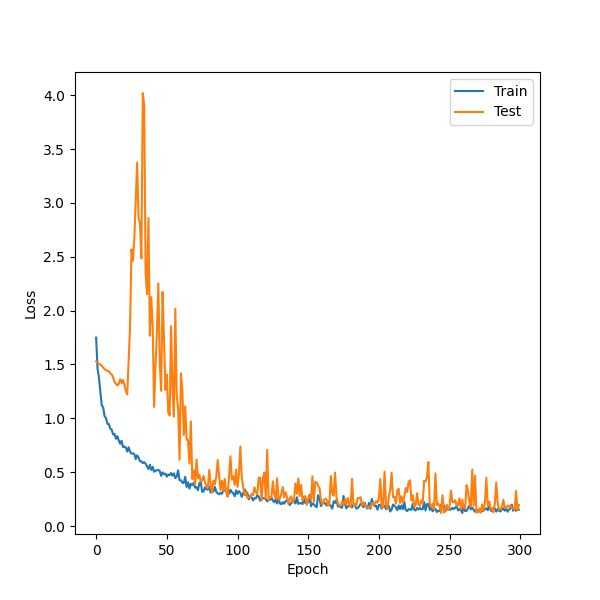

In [6]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True, batch_size=1# training parameters
)

Now let's make a prediction on the image from a different experiment ( the data is from our paper in *Applied Physics Letters 115, 052902 (2019)* ). Notice that the raw output is a set of semantically segmented blobs (corresponding to different atoms) on a uniform background. We then simply find their centers of the mass, which correspond to the atomic centers (if a network was properly trained).

In [ ]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.2056 seconds


Plot raw prediction:

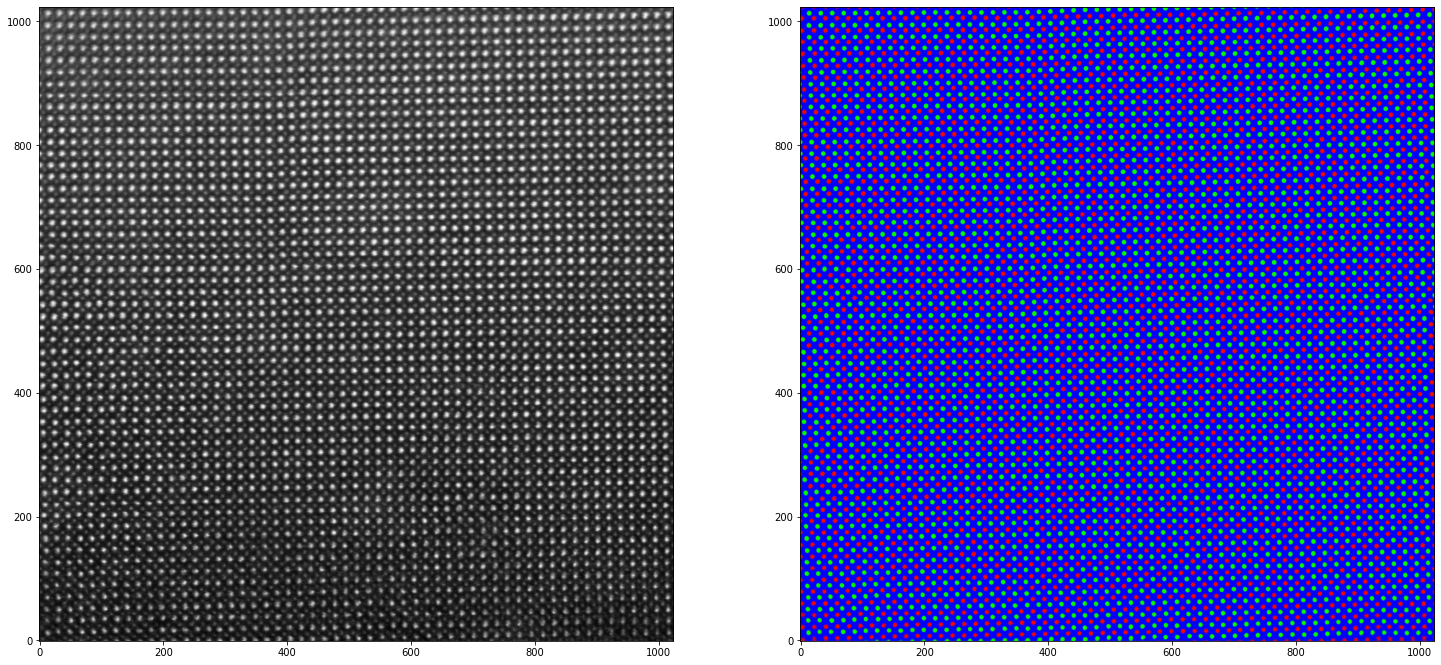

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

Plot atomic coordinates:

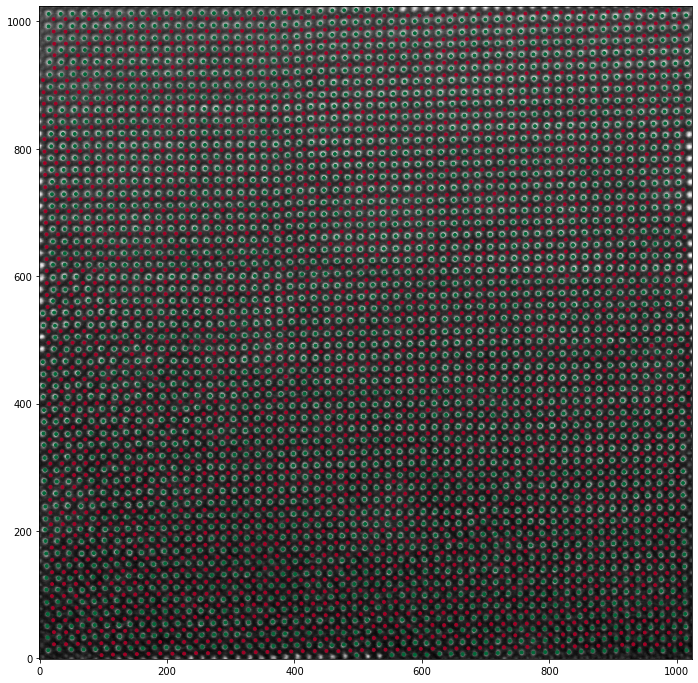

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

### Let's see how noisy we can make the image...

### AtomAI:
M. Ziatdinov, A. Ghosh, C. Y. Wong, and S. V. Kalinin,

“AtomAI framework for deep learning analysis of image and spectroscopy data in electron and scanning probe microscopy,”

Nature Machine Intelligence 2022 4:12, vol. 4, no. 12, pp. 1101–1112, Dec. 2022, doi: 10.1038/s42256-022-00555-8.